## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm

### Задача №1:
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 4')

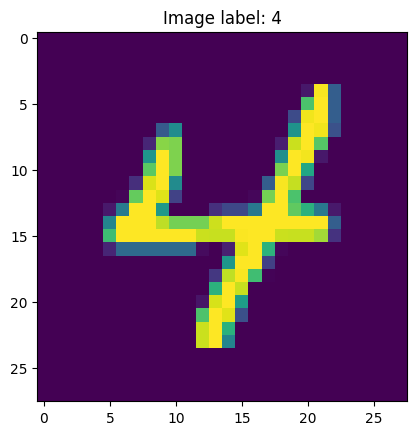

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [17]:
# Creating model instance
class BasicModel(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim - hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim - hidden_dim // 4, 10)

        self.act = nn.LeakyReLU()
       # self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = x.reshape(-1, 784)

        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))
        x = self.dropout(self.act(self.fc3(x)))
        x = self.fc4(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BasicModel(input_dim=784, hidden_dim=512) # your code here
model

BasicModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=384, bias=True)
  (fc4): Linear(in_features=384, out_features=10, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [18]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [20]:
# your code here
def train(model, train_data_loader, num_epochs=3):
    losses = []
    accuracies = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_accuracy = []
        for batch in tqdm(train_data_loader, desc=f'Training epoch {epoch+1}'):
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()
            outputs = model(batch[0])
            loss = criterion(outputs, batch[1])
            loss.backward()
            optimizer.step()

            predictions = outputs.argmax(-1)
            correct_predictions = (predictions == batch[1]).sum().item()
            accuracy = correct_predictions / batch[1].size(0)

            epoch_accuracy.append(accuracy)
            epoch_losses.append(loss.item())
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        avg_acc = sum(epoch_accuracy) / len(epoch_accuracy)
        accuracies.append(avg_acc)
        losses.append(avg_loss)

        print(f'Epoch {epoch+1}/{num_epochs}: Accuracy: {avg_acc:.4f}, Loss: {avg_loss:.4f}')

    return model

num_epochs = 3
model = train(model, train_data_loader, num_epochs=num_epochs)

Training epoch 1: 100%|██████████| 1875/1875 [00:14<00:00, 126.90it/s]


Epoch 1/3: Accuracy: 0.9527, Loss: 0.1578


Training epoch 2: 100%|██████████| 1875/1875 [00:14<00:00, 128.38it/s]


Epoch 2/3: Accuracy: 0.9704, Loss: 0.0983


Training epoch 3: 100%|██████████| 1875/1875 [00:15<00:00, 122.40it/s]

Epoch 3/3: Accuracy: 0.9772, Loss: 0.0767


In [21]:
model.to('cpu')

BasicModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=384, bias=True)
  (fc4): Linear(in_features=384, out_features=10, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
)

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [22]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(train_data_loader):
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

100%|██████████| 1875/1875 [00:13<00:00, 136.29it/s]


In [23]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.98547


In [24]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(test_data_loader):
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

100%|██████████| 313/313 [00:02<00:00, 111.30it/s]


In [25]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.978


Проверка, что необходимые пороги пройдены:

In [26]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [28]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

--2025-01-07 20:55:51--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw07_data_dict.npy.2’

hw07_data_dict.npy. 100%[===================>]   5.98M  --.-KB/s    in 0.1s    

2025-01-07 20:55:51 (40.5 MB/s) - ‘hw07_data_dict.npy.2’ saved [6272438/6272438]



In [29]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


In [30]:
submission_dict

{'train': array([0, 9, 0, 2, 8, 5, 7, 9, 4, 4, 0, 5, 7, 7, 0, 2, 4, 5, 5, 8, 7, 1,
        2, 5, 5, 7, 7, 7, 2, 2, 7, 2, 0, 1, 8, 6, 5, 2, 9, 6, 9, 8, 0, 4,
        4, 1, 9, 4, 4, 0, 3, 7, 7, 6, 3, 1, 3, 1, 0, 0, 3, 8, 0, 3, 1, 7,
        2, 5, 3, 5, 4, 2, 3, 4, 0, 1, 2, 1, 3, 2, 0, 8, 1, 7, 0, 2, 4, 5,
        0, 3, 1, 8, 9, 8, 8, 5, 9, 2, 9, 6, 3, 1, 9, 4, 3, 7, 0, 8, 6, 5,
        8, 6, 2, 4, 4, 8, 1, 5, 3, 6, 0, 6, 6, 9, 9, 9, 6, 7, 7, 7, 9, 0,
        6, 5, 7, 2, 0, 0, 8, 9, 7, 7, 9, 6, 8, 1, 2, 1, 5, 7, 1, 4, 4, 5,
        4, 3, 3, 8, 2, 0, 0, 3, 1, 0, 6, 4, 3, 6, 4, 4, 6, 2, 1, 8, 4, 3,
        7, 8, 8, 9, 9, 0, 3, 9, 9, 2, 3, 3, 9, 1, 1, 9, 6, 7, 8, 7, 6, 6,
        9, 3, 3, 2, 8, 2, 5, 4, 7, 2, 6, 9, 2, 7, 0, 8, 9, 6, 7, 0, 7, 6,
        1, 7, 1, 0, 9, 2, 2, 9, 3, 8, 0, 8, 6, 5, 1, 3, 2, 7, 9, 2, 0, 7,
        4, 9, 9, 6, 5, 9, 4, 6, 9, 2, 9, 5, 5, 3, 7, 6, 4, 3, 4, 0, 9, 3,
        3, 4, 8, 2, 6, 5, 1, 5, 8, 1, 5, 6, 0, 1, 1, 7, 6, 7, 5, 3, 1, 9,
        4, 2, 0, 6, 2, 1, 7, 

На этом задание завершено. Поздравляем!